## Constellation Map

The peak selection step reduces a complicated spectrogram representation of the signal to a sparse set of coordinates. Notice that the magnitudes of the peaks are no longer used&mdash;only the time and frequency stamps of the peaks are considered, which introduces
a high degree of robustness. In the following, the representation consisting of all peak coordinates is also referred to as a **constellation map**. This name is inspired by the observation that the spectral peak patterns look like groups of stars that form patterns on the celestial sphere. 

<!--The following figures shows a spectrogram representation with extracted peak fingerprints as well as the resulting constellation map.-->
<!--Illustration of the peak-based audio fingerprints using a recording of "Day Tripper" by The Beatles as an example.-->
<!--<img src="../data/C7/FMP_C7_F04.png" width="300px" align="middle" alt="FMP_C7_F04.png">-->

In the following code cell, we provide a naive implementation for extracting a constellation map for given **neighborhood parameters** $\tau$ and $\kappa$. In this implementation, we iteratively loop through all time-frequency points and check if the neighborhood condition (specified by $\kappa$ and $\tau$) is fulfilled. The figures shows a spectrogram representation along with a constellation map (the extracted peak fingerprints shown in red) for the Beatles example from above. 

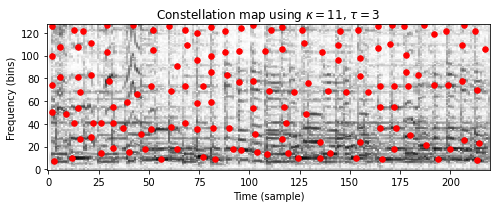

In [1]:
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6

%matplotlib inline

@jit(nopython=True)
def compute_constellation_map_naive(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (naive implementation)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    # spectrogram dimensions
    if Y.ndim > 1:
        (K, N) = Y.shape
    else:
        K = Y.shape[0]
        N = 1
    Cmap = np.zeros((K, N), dtype=np.bool8)

    # loop over spectrogram
    for k in range(K):
        f1 = max(k - dist_freq, 0)
        f2 = min(k + dist_freq + 1, K)
        for n in range(N):
            t1 = max(n - dist_time, 0)
            t2 = min(n + dist_time + 1, N)
            curr_mag = Y[k, n]
            curr_rect = Y[f1:f2, t1:t2]
            c_max = np.max(curr_rect)
            if ((curr_mag == c_max) and (curr_mag > thresh)):
                Cmap[k, n] = True
    return Cmap

def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im
    
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    x, Fs = librosa.load(fn_wav, Fs)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

wav_dict = {}
wav_dict['Original'] = [os.path.join('..', 'data', 'C7', 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4.wav')]
wav_dict['Noise'] = [os.path.join('..', 'data', 'C7', 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_NoiseSNR-9.wav')]
wav_dict['Talking'] = [os.path.join('..', 'data', 'C7', 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_Talking.wav')]
wav_dict['Coding'] = [os.path.join('..', 'data', 'C7', 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_16kbits.wav')]
wav_dict['Faster'] = [os.path.join('..', 'data', 'C7', 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_Faster.wav')]
wav_dict['Higher'] = [os.path.join('..', 'data', 'C7', 'FMP_C7_Audio_Beatles_ActNaturally_63-3_73-4_Higher.wav')]


fn_wav = wav_dict['Original'][-1]
Y = compute_spectrogram(fn_wav)

dist_freq = 11  # kappa: neighborhood in frequency direction
dist_time = 3   # tau: neighborhood in time direction
title=r'Constellation map using $\kappa=%d$, $\tau=%d$' % (dist_freq, dist_time)
Cmap_naive = compute_constellation_map_naive(Y, dist_freq, dist_time)
fig, ax, im = plot_constellation_map(Cmap_naive, np.log(1 + 1 * Y), 
                                     color='r', s=30, title=title)

As an alternative to the naive, iterative implementation, we provide in the next code cell a much faster implementation using the Python package `scipy.ndimage` for multi-dimensional image processing. In the following code cell, we compare the results (which should be the same) and runtimes of the two implementation.

<!--Even though the naive implementation is accelerated using `numba`, the `scipy`-implementation is much faster.-->

Runtime of naive (iterative) implementation: 0.00582719 seconds
Runtime of fast (scipy.ndimage) implementation: 0.00055249 seconds


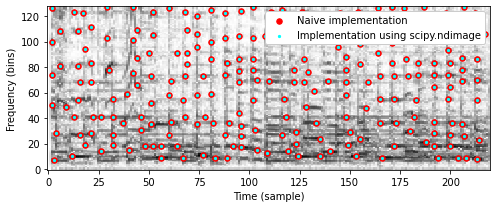

In [2]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap


dist_freq = 7  # kappa: neighborhood in frequency direction
dist_time = 3  # tau: neighborhood in time direction

start = time.time()
Cmap_naive = compute_constellation_map_naive(Y, dist_freq, dist_time)
end = time.time()
print('Runtime of naive (iterative) implementation: %.8f seconds' % (end - start))

start = time.time()
for i in range(100):
    Cmap = compute_constellation_map(Y, dist_freq, dist_time)
end = time.time()
print('Runtime of fast (scipy.ndimage) implementation: %.8f seconds' % ((end - start)/100))

fig, ax, im = plot_constellation_map(Cmap_naive, np.log(1 + 1 * Y), color='r', s=30)
n, k = np.argwhere(Cmap == 1).T
ax.scatter(k, n, color='cyan', s=5, marker='o')
plt.legend(['Naive implementation', 'Implementation using scipy.ndimage'], 
           loc='upper right', framealpha=1);

## Robustness of Constellation Maps

As described before, a fingerprinting system should be robust against background noise and signal distortions. In the following code cell, we show the constellation maps for the original Beatles example (`Original`), for the version superimposed with Gaussian noise (`Noise`), for the version with background noise (`Talking`), as well as for the version distorted by coding artifacts (`Coding`). Furthermore, we illustrate how the density of the constellation map can be controlled by the neighborhood parameters $\kappa$ and $\tau$. In both parameter settings, one can observe the following:

* The constellation maps of the distorted versions share some peaks with the original version.  
* The peaks of the distorted versions are sometimes slightly shifted in time and/or frequency compared with the ones of the original version.

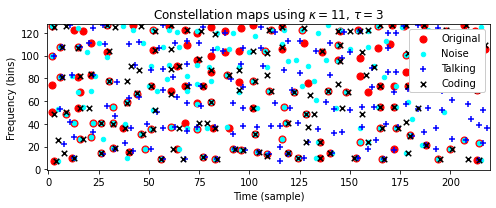

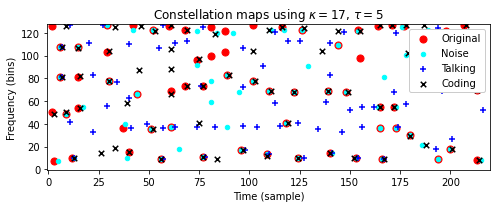

In [3]:
def compare_constellation_maps_Beatles(dist_freq = 11, dist_time = 3, wav_dict=wav_dict):
    fn_wav = wav_dict['Original'][-1]
    Y = compute_spectrogram(fn_wav)
    Cmap = compute_constellation_map(Y, dist_freq, dist_time)

    fn_wav = wav_dict['Noise'][-1]
    Y_noise = compute_spectrogram(fn_wav)
    Cmap_noise = compute_constellation_map(Y_noise, dist_freq, dist_time)

    fn_wav = wav_dict['Talking'][-1]
    Y_noise = compute_spectrogram(fn_wav)
    Cmap_talking = compute_constellation_map(Y_noise, dist_freq, dist_time)

    fn_wav = wav_dict['Coding'][-1]
    Y_coding = compute_spectrogram(fn_wav)
    Cmap_coding = compute_constellation_map(Y_coding, dist_freq, dist_time)

    title=r'Constellation maps using $\kappa=%d$, $\tau=%d$' % (dist_freq, dist_time)
    fig, ax, im = plot_constellation_map(Cmap, color='r', s=50,title=title)
    
    n, k = np.argwhere(Cmap_noise == 1).T
    ax.scatter(k, n, color='cyan', s=20, marker='o')
    
    n, k = np.argwhere(Cmap_talking == 1).T
    ax.scatter(k, n, color='blue', s=40, marker='+')

    n, k = np.argwhere(Cmap_coding == 1).T
    ax.scatter(k, n, color='k', s=30, marker='x')
    plt.legend(['Original', 'Noise', 'Talking', 'Coding'], loc='upper right', framealpha=1)
    return Cmap, Cmap_noise, Cmap_talking, Cmap_coding
    
compare_constellation_maps_Beatles(dist_freq = 11, dist_time = 3)
compare_constellation_maps_Beatles(dist_freq = 17, dist_time = 5);

## Evaluation Measures for Peak Matching

In practice, it turns out that even a small percentage of coinciding peaks (while allowing a small tolerance in time and frequency direction) is often sufficient to successfully identify a recording even in the presence of distortions. This observation is the basis for the matching procedure to be described below. We now introduce some **evaluation measures** that indicate the agreement between two constellation maps. We interpret the first constellation map as **reference** (its peaks being considered **relevant**) and the second one as **estimation** (its peaks being considered **estimated**). This allows us to use terms such as **true positives** (TP), **false positives** (FP), and **false negatives** (FN), which we introduced in the [FMP notebook on evaluation](../C4/C4S5_Evaluation.html) in the context of [music structure analysis](../C4/C4.html). In the following code cell, we implement a function for measuring TP, FP, and FN values, while allowing some **tolerance**. A similar concept was used in the context of [boundary evaluation](../C4/C4S5_Evaluation.html), see also Section 4.5.4 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. We continue with our Beatles example considering the original, noise, coding, and talking versions.

====== Reference: Original; Estimation: Noise ======


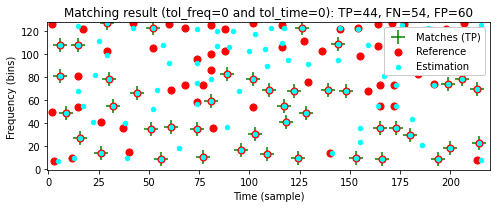

====== Reference: Original; Estimation: Noise ======


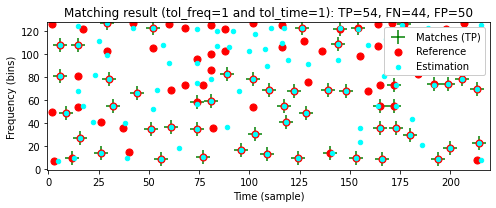

====== Reference: Original; Estimation: Coding ======


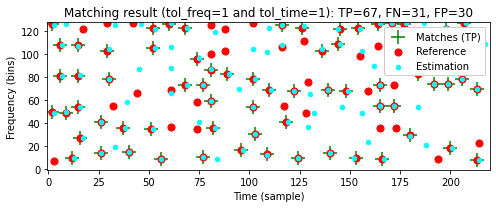

====== Reference: Original; Estimation: Talking ======


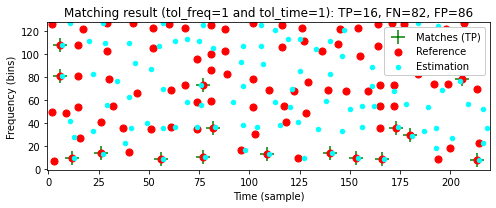

In [4]:
def match_binary_matrices_tol(C_ref, C_est, tol_freq=0, tol_time=0):
    """| Compare binary matrices with tolerance
    | Note: The tolerance parameters should be smaller than the minimum distance of
      peaks (1-entries in C_ref ad C_est) to obtain meaningful TP, FN, FP values

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        C_ref (np.ndarray): Binary matrix used as reference
        C_est (np.ndarray): Binary matrix used as estimation
        tol_freq (int): Tolerance in frequency direction (vertical) (Default value = 0)
        tol_time (int): Tolerance in time direction (horizontal) (Default value = 0)

    Returns:
        TP (int): True positives
        FN (int): False negatives
        FP (int): False positives
        C_AND (np.ndarray): Boolean mask of AND of C_ref and C_est (with tolerance)
    """
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"
    N = np.sum(C_ref)
    M = np.sum(C_est)
    # Expand C_est with 2D-max-filter using the tolerance parameters
    C_est_max = ndimage.maximum_filter(C_est, size=(2*tol_freq+1, 2*tol_time+1),
                                       mode='constant')
    C_AND = np.logical_and(C_est_max, C_ref)
    TP = np.sum(C_AND)
    FN = N - TP
    FP = M - TP
    return TP, FN, FP, C_AND

def compare_constellation_maps(fn_wav_D, fn_wav_Q, dist_freq = 11, dist_time = 5, 
                               tol_freq = 1, tol_time = 1):
    Y_D = compute_spectrogram(fn_wav_D)
    Cmap_D = compute_constellation_map(Y_D, dist_freq, dist_time)
    Y_Q = compute_spectrogram(fn_wav_Q)
    Cmap_Q = compute_constellation_map(Y_Q, dist_freq, dist_time)

    TP, FN, FP, Cmap_AND = match_binary_matrices_tol(Cmap_D, Cmap_Q, 
                                                     tol_freq=tol_freq, tol_time=tol_time)
    title=r'Matching result (tol_freq=%d and tol_time=%d): TP=%d, FN=%d, FP=%d' % \
        (tol_freq,tol_time, TP, FN, FP)
    fig, ax, im = plot_constellation_map(Cmap_AND, color='green', s=200, marker='+', title=title)
    n, k = np.argwhere(Cmap_D == 1).T
    ax.scatter(k, n, color='r', s=50, marker='o')
    n, k = np.argwhere(Cmap_Q == 1).T
    ax.scatter(k, n, color='cyan', s=20, marker='o')
    plt.legend(['Matches (TP)', 'Reference', 'Estimation'], loc='upper right', framealpha=1)
    plt.tight_layout()
    plt.show()


fn_wav_D = wav_dict['Original'][-1]
fn_wav_Q = wav_dict['Noise'][-1]
tol_freq = 0
tol_time = 0
print('====== Reference: Original; Estimation: Noise ======')
compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

tol_freq = 1
tol_time = 1
print('====== Reference: Original; Estimation: Noise ======')
compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

fn_wav_Q = wav_dict['Coding'][-1]
tol_freq = 1
tol_time = 1
print('====== Reference: Original; Estimation: Coding ======')
compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

fn_wav_Q = wav_dict['Talking'][-1]
tol_freq = 1
tol_time = 1
print('====== Reference: Original; Estimation: Talking ======')
compare_constellation_maps(fn_wav_D, fn_wav_Q, tol_freq=tol_freq, tol_time=tol_time)

## Matching Function
 
Let us consider a short query audio fragment, called $\mathcal{Q}$, as well as a database recording, called $\mathcal{D}$. Furthermore, let $\mathcal{C}(\mathcal{Q})$ and $\mathcal{C}(\mathcal{D})$ denote the constellation maps of $\mathcal{Q}$ and $\mathcal{D}$, respectively. In the case that the query $\mathcal{Q}$ is contained in the recording $\mathcal{D}$, the constellation map $\mathcal{C}(\mathcal{Q})$ should more or less agree with the corresponding section within the constellation map $\mathcal{C}(\mathcal{D})$. Intuitively, the basic idea of audio identification is to put the constellation map of $\mathcal{D}$ on a strip chart and the constellation map of $\mathcal{Q}$ on a transparent piece of plastic. The latter is then shifted over the former, and when the number of matching points is significant, the query is considered to be contained in the document. The proper time offset of the matching position within $\mathcal{C}(\mathcal{D})$ is given by the shift. 

We now formalize the outlined matching procedure. Recall that a peak position is specified by its coordinates $(n,k)$ consisting of a time stamp $n\in\mathbb{Z}$ and a frequency stamp $k\in[0:K]$. A constellation map is then a finite set of such coordinates. As before, let $\mathcal{C}(\mathcal{Q})\subset \mathbb{Z}\times[0:K]$ and $\mathcal{C}(\mathcal{D})\subset \mathbb{Z}\times[0:K]$ be the constellation maps of the query $\mathcal{Q}$ and the document $\mathcal{D}$, respectively. Shifting the query by $m\in\mathbb{Z}$ positions yields the constellation map $m+\mathcal{C}(\mathcal{Q})$ defined by

\begin{equation}
    m+\mathcal{C}(\mathcal{Q}) := \left\{(m+n,k) \mid (n,k)\in \mathcal{C}(\mathcal{Q}) \right\}.
\end{equation}

To count the matching peak coordinates between a shifted query and a database document, 
we simply need to intersect the corresponding constellation maps and to determine the size of the resulting set. This yields a matching function $\Delta_\mathcal{C}:\mathbb{Z}\to\mathbb{N}_0$ defined by 

\begin{equation}
    \Delta_\mathcal{C}(m):= \big| (m+\mathcal{C}(\mathcal{Q}))\cap  \mathcal{C}(\mathcal{D}) \big|
\end{equation}

for $m\in\mathbb{Z}$. In general, when the query and the database documents are unrelated,
the number $\Delta_\mathcal{C}(m)$ of (coincidentally) matching peak positions is usually small compared with $|\mathcal{C}(\mathcal{Q})|$. Only if the query is contained in the database document will the matching function have a large value $\Delta_\mathcal{C}(m)$ for some shift index $m\in\mathbb{Z}$. This index indicates the time offset between the query $\mathcal{Q}$ and the matching section in $\mathcal{D}$.

<!--
The following figure shows an example of a matching  function $\Delta_\mathcal{C}$, which assumes its maximum at the matching position corresponding to the time offset $t=4.5~\mathrm{sec}$. Even in the case of spurious and missing peaks due to signal degradations, the query may be correctly identified as long as the number of correctly matching peak coordinates is statistically significant.

<img src="../data/C7/FMP_C7_F05.png" width="600px" align="middle" alt="FMP_C7_F05.png">
-->

In the next code cell, we provide an implementation for a generalized matching function $\Delta_\mathcal{C}$ that also allows for small deviations (specified by tolerance parameters `tol_freq` and `tol_time`). As for the implementation, please note the following:

* When computing $\Delta_\mathcal{C}(m)$, the shifted query $m+\mathcal{C}(\mathcal{Q})$ is compared with $\mathcal{C}(\mathcal{D})$. This is equivalent to cutting out a section of $\mathcal{C}(\mathcal{D})$  starting at position $m$ with the same length as the query and to compare this section with $\mathcal{C}(\mathcal{Q})$.

* When comparing the constellation maps of $\mathcal{Q}$ and $\mathcal{D}$, we are interested in the number of matching peaks. This corresponds to the number of true positives (TP), when regarding $\mathcal{D}$ as reference and $\mathcal{Q}$ as estimation.

* In the comparison, we use the function `match_binary_matrices_tol`, which has the two tolerance parameters `tol_freq` and `tol_time`. Setting these parameters to the value $0$ yields the matching function $\Delta_\mathcal{C}$ as introduced above.

We continue with our Beatles example using `Original` as $\mathcal{D}$ and the segment $[100:149]$ (given in samples) of `Noise` as $\mathcal{Q}$. The following figure shows matching functions for different tolerance parameters. Note that these functions assume their maximum at the shift position $m=100$.

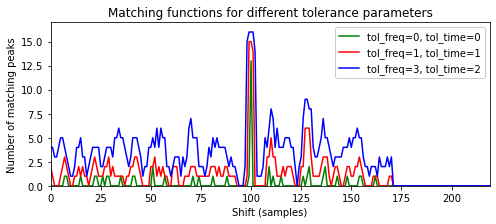

In [5]:
def compute_matching_function(C_D, C_Q, tol_freq=1, tol_time=1):
    """Computes matching function for constellation maps

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        C_D (np.ndarray): Binary matrix used as dababase document
        C_Q (np.ndarray): Binary matrix used as query document
        tol_freq (int): Tolerance in frequency direction (vertical) (Default value = 1)
        tol_time (int): Tolerance in time direction (horizontal) (Default value = 1)

    Returns:
        Delta (np.ndarray): Matching function
        shift_max (int): Optimal shift position maximizing Delta
    """
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"
    Delta = np.zeros(L)
    for m in range(M + 1):
        C_D_crop = C_D[:, m:m+N]
        TP, FN, FP, C_AND = match_binary_matrices_tol(C_D_crop, C_Q,
                                                      tol_freq=tol_freq, tol_time=tol_time)
        Delta[m] = TP
    shift_max = np.argmax(Delta)
    return Delta, shift_max

dist_freq = 11
dist_time = 5

fn_wav_D = wav_dict['Original'][-1]
Y_D = compute_spectrogram(fn_wav_D)
Cmap_D = compute_constellation_map(Y_D, dist_freq, dist_time)

fn_wav_Q = wav_dict['Noise'][-1]
Y_Q = compute_spectrogram(fn_wav_Q)
Y_Q = Y_Q[:, 100:150]
Cmap_Q = compute_constellation_map(Y_Q, dist_freq, dist_time)

Delta_0, shift_max_0 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=0, tol_time=0)
Delta_1, shift_max_1 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=1, tol_time=1)
Delta_2, shift_max_2 = compute_matching_function(Cmap_D, Cmap_Q, tol_freq=3, tol_time=2)

y_max = Delta_2[shift_max_2] + 1
fig, ax, line = libfmp.b.plot_signal(Delta_0, ylim=[0, y_max], color='g',
                                     xlabel='Shift (samples)', ylabel='Number of matching peaks', 
                                     figsize=(7, 3))
plt.title('Matching functions for different tolerance parameters')
ax.plot(Delta_1, color='r')
ax.plot(Delta_2, color='b')
plt.legend(['tol_freq=0, tol_time=0', 'tol_freq=1, tol_time=1', 
            'tol_freq=3, tol_time=2'], loc='upper right', framealpha=1)
plt.show()

In the next code cell, we show the local matching result between the shifted query $m+\mathcal{C}(\mathcal{Q})$ and $\mathcal{C}(\mathcal{D})$ for different shift indices $m$. Note there are hardly any matching peaks for $m=0$, while there are many matching peaks for the optimal shift index $m=99$. 

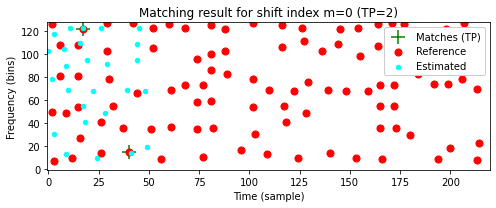

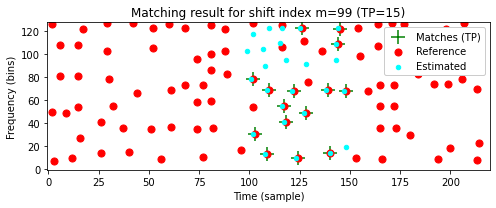

In [6]:
def plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=0):
    Cmap_Q_extend = np.zeros(Cmap_D.shape) 
    Cmap_Q_extend[:, shift:shift+Cmap_Q.shape[1]] = Cmap_Q
    TP, FN, FP, Cmap_AND = match_binary_matrices_tol(Cmap_D, Cmap_Q_extend, 
                                                     tol_freq=1, tol_time=1)
    title=r'Matching result for shift index m=%d (TP=%d)' % (shift, TP)
    fig, ax, im = plot_constellation_map(Cmap_AND, color='green', s=200, marker='+', title=title)
    n, k = np.argwhere(Cmap_D == 1).T
    ax.scatter(k, n, color='r', s=50, marker='o')
    n, k = np.argwhere(Cmap_Q_extend == 1).T
    ax.scatter(k, n, color='cyan', s=20, marker='o')
    plt.legend(['Matches (TP)', 'Reference', 'Estimated'], loc='upper right', framealpha=1)
    plt.show()
    
plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=0)    
plot_shifted_Cmap(Cmap_D, Cmap_Q, shift=shift_max_1) 

## Matching Functions for Beatles Examples 

We now have a look at the matching functions obtained from different versions of the Beatles example. As before, we use `Original` as $\mathcal{D}$ and the segment $[100:149]$ (given in samples) of other versions as $\mathcal{Q}$. The following figure shows matching functions for the queries `Original`, `Noise`, `Coding`, and `Talking`. While one can observe a distinct maximum in the matching function at the expected matching positions for the first three queries, the `Talking` query is much harder to identify.

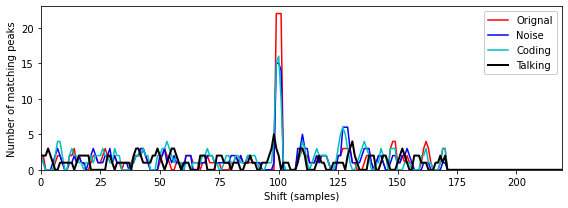

In [7]:
def compute_Delta(fn_wav_D, fn_wav_Q, seg_start=100, seg_end=150, dist_freq=11, 
                  dist_time=5, tol_freq=1, tol_time=1):
    Y_D = compute_spectrogram(fn_wav_D)
    Cmap_D = compute_constellation_map(Y_D, dist_freq=dist_freq, dist_time=dist_time)
    Y_Q = compute_spectrogram(fn_wav_Q)
    Y_Q = Y_Q[:, seg_start:seg_end]
    Cmap_Q = compute_constellation_map(Y_Q, dist_freq=dist_freq, dist_time=dist_time)
    Delta, shift_max = compute_matching_function(Cmap_D, Cmap_Q, 
                                                 tol_freq=tol_freq, tol_time=tol_time)
    return Delta, shift_max

fn_wav_Q = wav_dict['Original'][-1]    
Delta_0, shift_max_0 = compute_Delta(fn_wav_D, fn_wav_Q)
fn_wav_Q = wav_dict['Noise'][-1]
Delta_1, shift_max_1 = compute_Delta(fn_wav_D, fn_wav_Q)
fn_wav_Q = wav_dict['Coding'][-1]
Delta_2, shift_max_2 = compute_Delta(fn_wav_D, fn_wav_Q)
fn_wav_Q = wav_dict['Talking'][-1]
Delta_3, shift_max_3 = compute_Delta(fn_wav_D, fn_wav_Q)

y_max = Delta_0[shift_max_0] + 1
fig, ax, line = libfmp.b.plot_signal(Delta_0, ylim=[0, y_max], color='r',
                                     xlabel='Shift (samples)', 
                                     ylabel='Number of matching peaks', 
                                     figsize=(8, 3))
ax.plot(Delta_1, color='b')
ax.plot(Delta_2, color='c')
ax.plot(Delta_3, color='k', linewidth='2')
plt.legend(['Orignal', 'Noise', 'Coding', 'Talking'], loc='upper right', framealpha=1)
plt.show()

In the previous example, we have seen that correct segment in the `Original` Beatles song can hardly be identified when using the segment $[100:149]$ (given in samples) of the `Talking` version. One way to increase the **discriminative power** of the query constellation map is to increase its duration (see also the discussion of specificity and granularity in the [FMP notebook on content-based audio retrieval](../C7/C7_ContentBasedAudioRetrieval.html)). To demonstrate this, we show in the subsequent figure the matching functions for queries of different lengths:

* Segment $[100:149]$ (corresponding to 2.32 seconds)
* Segment $[100:174]$ (corresponding to 3.48 seconds)
* Segment $[100:199]$ (corresponding to 4.64 seconds)

In the case of the longest query, the peak structure becomes more prominent even in the case of the strongly distorted `Talking` version.

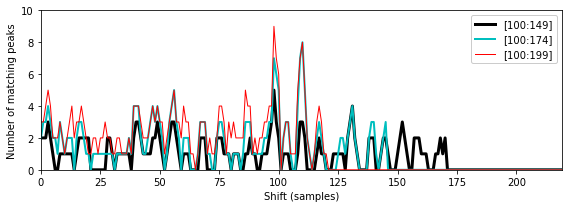

In [8]:
fn_wav_Q = wav_dict['Talking'][-1]
Delta_0, shift_max_0 = compute_Delta(fn_wav_D, fn_wav_Q)
Delta_1, shift_max_1 = compute_Delta(fn_wav_D, fn_wav_Q, seg_start=100, seg_end=175)
Delta_2, shift_max_2 = compute_Delta(fn_wav_D, fn_wav_Q, seg_start=100, seg_end=200)

y_max = Delta_2[shift_max_2] + 1
fig, ax, line = libfmp.b.plot_signal(Delta_0, ylim=[0, y_max], color='k',
                                     xlabel='Shift (samples)', 
                                     ylabel='Number of matching peaks', 
                                     figsize=(8, 3), linewidth=3)
ax.plot(Delta_1, color='c', linewidth=2)
ax.plot(Delta_2, color='r', linewidth=1)
plt.legend(['[100:149]', '[100:174]', '[100:199]'], loc='upper right', framealpha=1)
plt.show()

We close our discussion on the matching functions by considering the two versions `Faster` (time-scale modified version played about 10 percent faster) and `Higher` (pitch-shifted version). Again using `Original` as $\mathcal{D}$ and the segment $[100:174]$ of other versions as $\mathcal{Q}$, the subsequent figure shows the resulting matching functions. As defined above, a matching function compares constellation maps in a rather strict sense: systematic shifts in frequency and global time stretches are not accounted for. As a result, versions such as `Faster` or `Higher` cannot be identified by the techniques discussed so far.

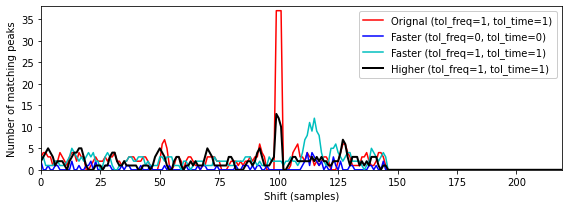

In [9]:
fn_wav_Q = wav_dict['Original'][-1]    
Delta_0, shift_max_0 = compute_Delta(fn_wav_D, fn_wav_Q, 
                                     seg_start=100, seg_end=175, tol_freq=1, tol_time=1)
fn_wav_Q = wav_dict['Faster'][-1]
Delta_1, shift_max_1 = compute_Delta(fn_wav_D, fn_wav_Q, 
                                     seg_start=100, seg_end=175, tol_freq=0, tol_time=0)
Delta_2, shift_max_1 = compute_Delta(fn_wav_D, fn_wav_Q, 
                                     seg_start=100, seg_end=175, tol_freq=1, tol_time=1)
fn_wav_Q = wav_dict['Higher'][-1]
Delta_3, shift_max_2 = compute_Delta(fn_wav_D, fn_wav_Q, 
                                     seg_start=100, seg_end=175, tol_freq=1, tol_time=1)

y_max = Delta_0[shift_max_0] + 1
fig, ax, line = libfmp.b.plot_signal(Delta_0, ylim=[0, y_max], color='r',
                                     xlabel='Shift (samples)', 
                                     ylabel='Number of matching peaks', 
                                     figsize=(8, 3))
ax.plot(Delta_1, color='b')
ax.plot(Delta_2, color='c')
ax.plot(Delta_3, color='k', linewidth='2')
plt.legend([r'Orignal (tol_freq=1, tol_time=1)', r'Faster (tol_freq=0, tol_time=0)', 
            r'Faster (tol_freq=1, tol_time=1)', r'Higher (tol_freq=1, tol_time=1)'], loc='upper right', framealpha=1)
plt.show()